In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

In [ ]:
# Load images and labels
def load_images_and_labels(folder_path, image_size=(224, 224)):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            image = imread(file_path)
            if image is not None:
                image = resize(image, image_size, anti_aliasing=True)
                images.append(image)
                label = file.rsplit('_', 1)[0]
                labels.append(label)
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return np.array(images), np.array(labels)


In [ ]:
# Load dataset
folder_path = 'C:/Users/ASUS/Documents/Research/Model/Data/Mendeley/classificacao_binaria/400X/'
images, labels = load_images_and_labels(folder_path)

img_train, img_test, lbl_train, lbl_test = train_test_split(images, labels, test_size=0.2, random_state=42)


# Data Preprocessing

In [ ]:
# Normalize the data
img_train = img_train / 255.0
img_test = img_test / 255.0

In [ ]:

# Define ImageDataGenerator with optimized augmentations
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented data
def augment_data(X, y, datagen, target_size):
    augment_size = target_size - len(X)
    X_augmented, y_augmented = [], []

    for X_batch, y_batch in datagen.flow(X, y, batch_size=32):
        X_augmented.extend(X_batch[:augment_size - len(X_augmented)])
        y_augmented.extend(y_batch[:augment_size - len(y_augmented)])

        if len(X_augmented) >= augment_size:
            break

    return np.vstack((X, X_augmented)), np.hstack((y, y_augmented))

In [ ]:
# Target size for the augmented data
target_size = 2000

# Generate augmented data
img_augmented, lbl_augmented = augment_data(img_train, lbl_train, datagen, target_size)

# Combine original and augmented data
img_train_combined = np.vstack((img_train, img_augmented))
lbl_train_combined = np.hstack((lbl_train, lbl_augmented))

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_train_encoded = label_encoder.fit_transform(lbl_train_combined)
lbl_test_encoded = label_encoder.transform(lbl_test)

num_classes = len(label_encoder.classes_)

# Convert labels to categorical
lbl_train_encoded = to_categorical(lbl_train_encoded, num_classes=num_classes)
lbl_test_encoded = to_categorical(lbl_test_encoded, num_classes=num_classes)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
lbl_train_encoded = label_encoder.fit_transform(lbl_train)
lbl_test_encoded = label_encoder.transform(lbl_test)

num_classes = len(label_encoder.classes_)
num_classes
# Convert labels to categorical
lbl_train_encoded = to_categorical(lbl_train_encoded, num_classes=num_classes)
lbl_test_encoded = to_categorical(lbl_test_encoded, num_classes=num_classes)

# CNN Model

In [ ]:
# Define the CNN model
cnn_model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(lbl_train_combined), y=lbl_train_combined)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


# Train the CNN model
history = cnn_model.fit(img_train_combined, lbl_train_encoded, epochs=96, batch_size=32,
                        validation_data=(img_test, lbl_test_encoded)
                        , class_weight=class_weights_dict)


Epoch 1/96
108/108 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.6227 - loss: 0.6606 - val_accuracy: 0.8159 - val_loss: 0.4726
Epoch 2/96
108/108 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7944 - loss: 0.5051 - val_accuracy: 0.7940 - val_loss: 0.4830
Epoch 3/96
108/108 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.8172 - loss: 0.4655 - val_accuracy: 0.8269 - val_loss: 0.4112
Epoch 4/96
108/108 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.8547 - loss: 0.4225 - val_accuracy: 0.8434 - val_loss: 0.3943
Epoch 5/96
108/108 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.8626 - loss: 0.3977 - val_accuracy: 0.8324 - val_loss: 0.3918
Epoch 6/96
108/108 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.8630 - loss: 0.3954 - val_accuracy: 0.8599 - val_loss: 0.3944
Epoch 7/96
108/108 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8569 - loss: 0.3901 - val_accuracy: 0.8626 - val_loss: 0.3697
Epoch 8/96
108/108 ━━━━━━━━━━━━━━━━━━━━ 88s 812ms/step - accuracy: 0.8750 - loss: 0.3564 - val_ac

In [ ]:

# Train the CNN model
history = dnn_model.fit(img_train, lbl_train_encoded, epochs=56, batch_size=32,
                        validation_data=(img_test, lbl_test_encoded))


# Evaluation

In [ ]:

# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(img_test, lbl_test_encoded)
print(f"Test accuracy: {test_acc:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.8383 - loss: 0.9638
Test accuracy: 0.8599


In [ ]:
print(f"Test loss: {test_loss:.4f}")

Test loss: 0.5266


In [ ]:

# Generate classification report
lbl_pred_proba = cnn_model.predict(img_test)
lbl_pred = np.argmax(lbl_pred_proba, axis=1)
lbl_test_labels = np.argmax(lbl_test_encoded, axis=1)

print("Classification Report:\n", classification_report(lbl_test_labels, lbl_pred, target_names=label_encoder.classes_))


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step
Classification Report:
                precision    recall  f1-score   support

   BenignCase       0.84      0.71      0.77       122
MalignantCase       0.87      0.93      0.90       242

     accuracy                           0.86       364
    macro avg       0.86      0.82      0.84       364
 weighted avg       0.86      0.86      0.86       364



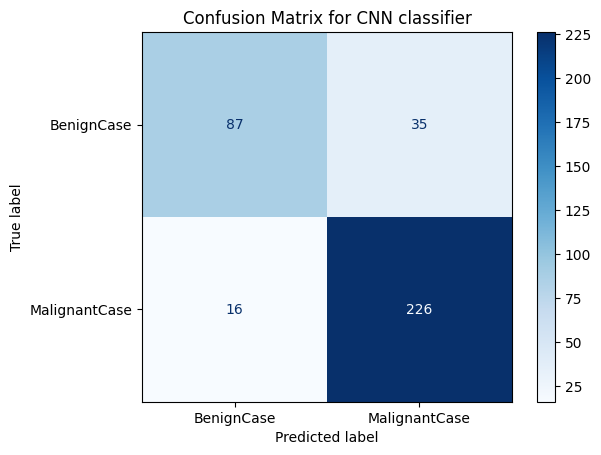

In [ ]:
# Generate Confusion Matrix
cm_cnn = confusion_matrix(lbl_test_labels, lbl_pred)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=label_encoder.classes_)
disp_cnn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN classifier')
plt.show()


In [ ]:
# Saliency map function
def compute_saliency(model, img_array, class_idx):
    img_array = tf.convert_to_tensor(img_array)  # Convert numpy array to tensor
    with tf.GradientTape() as tape:
        tape.watch(img_array)
        preds = model(img_array)
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, img_array)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    saliency = saliency.numpy()

    return saliency

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


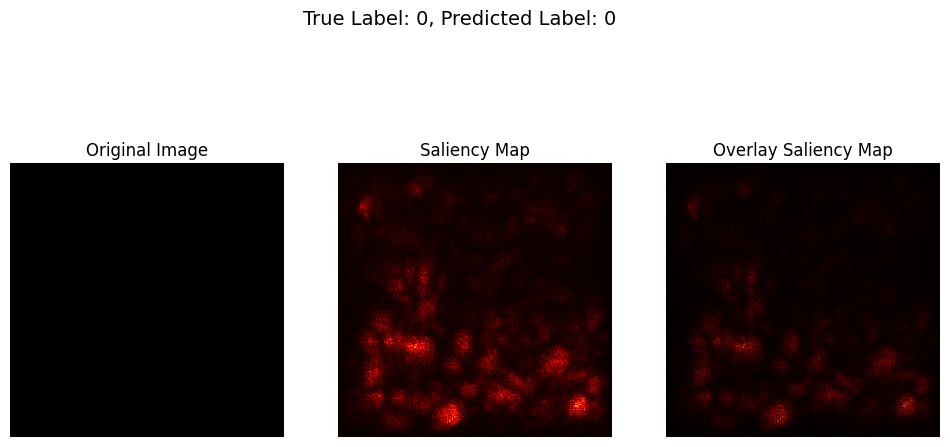

In [ ]:

# Example usage
img_idx = 100 # Index of the image you want to visualize
img_array = np.expand_dims(img_test[img_idx], axis=0)
class_idx = np.argmax(lbl_test_encoded[img_idx])  # Index of the true class
# Predict the class
preds = cnn_model.predict(img_array)
pred_class_idx = np.argmax(preds[0])

# Compute saliency
saliency = compute_saliency(cnn_model, img_array, class_idx)

# Normalize saliency map
saliency = saliency[0]
saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))

# Display saliency map
plt.figure(figsize=(12, 6))

# Display the original image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_test[img_idx].astype('uint8'))
plt.axis('off')

# Display the saliency map only
plt.subplot(1, 3, 2)
plt.title("Saliency Map")
plt.imshow(saliency, cmap='hot')
plt.axis('off')

# Overlay the saliency map on the original image
plt.subplot(1, 3, 3)
plt.title("Overlay Saliency Map")
plt.imshow(img_test[img_idx].astype('uint8'))
plt.imshow(saliency, cmap='hot', alpha=0.5)
plt.axis('off')

# Annotate with true and predicted labels
true_label = np.argmax(lbl_test_encoded[img_idx])
pred_label = np.argmax(preds)
plt.suptitle(f"True Label: {true_label}, Predicted Label: {pred_label}", fontsize=14)

plt.show()